In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from tqdm.notebook import tqdm

In [4]:
from paper_meta import *

In [5]:
task = mnist.MNIST()
task.load_all_data()

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
class Net(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 10)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
n_dim = util.count_params(Net())

In [29]:
device = 'cuda:0'
net = models_pheno.BigConvNet()
net = net.to(device)
def fit_mnist(pop):
    pop = pop.to(device)
    fit = task.calc_pop_fitness(pop, geno2pheno=lambda x: util.vec2model(x, net), device=device)
    return torch.from_numpy(fit.sel(metric='loss').data)
optim_fn = fit_mnist

  0%|          | 0/10 [00:00<?, ?it/s]

/work2/08258/akumar01/maverick2/evolved-neuroevolution/models_pheno.py:30: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  x = torch.relu(torch.max_pool2d(self.conv1(x), 2))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

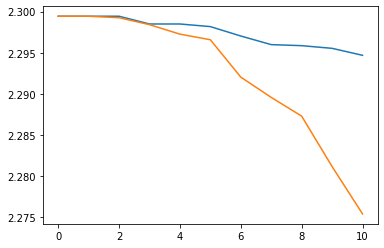

In [9]:
pop = torch.randn(21, n_dim)/10.
pops, fits = optim.run_evolution_base(pop, fit_mnist, 10, mr=1e-2, tqdm=tqdm)
plt.plot(fits.min(dim=-1).values)
pops, fits, mrs, mr_fits = optim.run_evolution_ours(pop, fit_mnist, 10, n_mutpop=5, tqdm=tqdm)
plt.plot(fits.min(dim=-1).values)
plt.show()

In [34]:
viz.plot_mean_std(f, 'gsmr', 'r', )

<function viz.plot_mean_std(f, name, c, logscale=False, render_mean=True, render_std=True, render_plots=True)>

  0%|          | 0/6 [00:00<?, ?it/s]

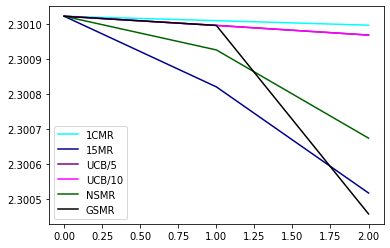

In [14]:
pop = torch.randn(21, n_dim)/10.

optim_fn = fit_mnist
n_gen = 2
n_seeds = 1


data = []
for seed in range(n_seeds):
    for algo in tqdm(algos_normal):
        do_seed(seed)
        res = algo2algo_fn[algo](pop, optim_fn, n_gen)
        pops, fits, mrs = res[:3]
        
        fits = fits.min(dim=-1).values
        plt.plot(fits, c=algo2color[algo], label=algo2label[algo])

plt.legend()

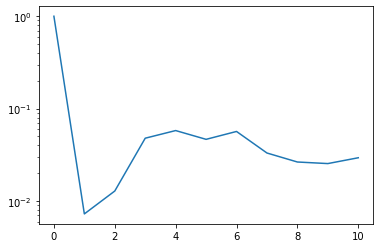

In [32]:
plt.plot(mrs[:, :, 0].log().mean(dim=-1).exp())
plt.yscale('log')

In [98]:
def create_experiment1_config():
    optim_fns = [ackley, rastrigin, rosenbrock, sphere, lin_fn]
    n_dims = [2, 30, 100, 1000]
    # init_pop_vars = [.1, 1, 5, 10]
    init_pop_vars = [1, 10]
    n_seed = 1
    n_gen = 500
    n_pop = 101

    config = []

    for optim_fn in optim_fns:
        for n_dim in n_dims:
            for init_pop_var in init_pop_vars:
#                 for algo in algos_normal:
                for algo in ['gsmr']:
                    ng = n_gen
                    if optim_fn==lin_fn:
                        ng = 100
                    elif optim_fn==ackley and n_dim==1000:
                        ng = 4000
                    config_i = {
                        'optim_fn': optim_fn,
                        'n_dim': n_dim,
                        'init_pop_var': init_pop_var,
                        'n_gen': ng,
                        'n_pop': n_pop,
                        'algo': algo,
                        'n_seed': n_seed,
                    }
                    config.append(config_i)

    data = []
    
    for ci in config:
        di = np.zeros((ci['n_seed'], ci['n_gen']+1, 2))
        di = xr.DataArray(di, dims=('seed', 'gen', 'fits_mrs'),
                            coords={'seed': list(range(ci['n_seed'])),
                                    'gen': list(range(ci['n_gen']+1)),
                                    'fits_mrs': ['fits', 'mrs']})
        data.append(di)
    return config, data
config, data = create_experiment1_config()

In [99]:
for ci, di in zip(tqdm(config), data):
    for seed in range(ci['n_seed']):
        do_seed(0)
        pop = torch.randn(ci['n_pop'], ci['n_dim'])*ci['init_pop_var']
        res = algo2algo_fn[ci['algo']](pop, ci['optim_fn'], ci['n_gen'])
        pops, fits, mrs = res[:3]
        fits = fits.min(dim=-1).values
        while mrs.ndim>1:
            mrs = mrs.log().mean(dim=-1).exp()
        
        a = di.sel(seed=seed, fits_mrs='fits')
        a[:] = fits.detach().cpu().numpy()
        a = di.sel(seed=seed, fits_mrs='mrs')
        a[:] = mrs.detach().cpu().numpy()


  0%|          | 0/40 [00:00<?, ?it/s]

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


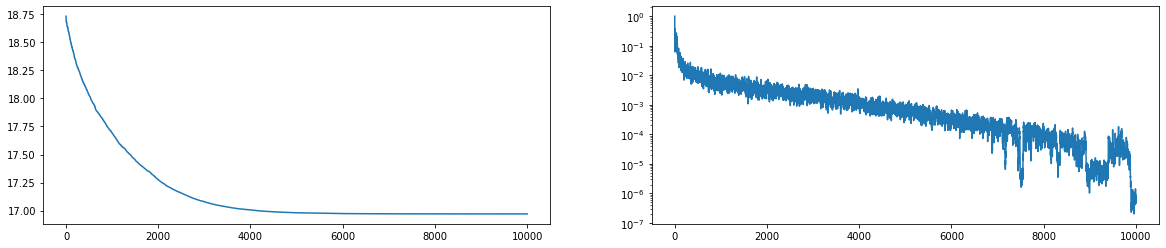

In [109]:
print(config[7])
plt.figure(figsize=(20,4))
plt.subplot(121);plt.plot(data[7][0, :, 0])
plt.subplot(122);plt.plot(data[7][0, :, 1])
plt.yscale('log')

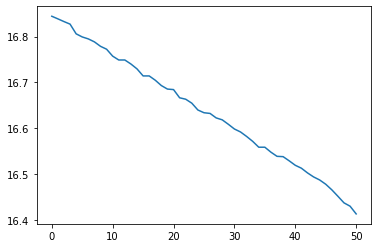

In [122]:
pop = torch.randn(101, 40)*10.
pops, fits = optim.run_evolution_base(pop, ackley, 50, mr=1e-2)
plt.plot(fits.min(dim=-1).values);

In [123]:
fits.shape

torch.Size([51, 101])

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


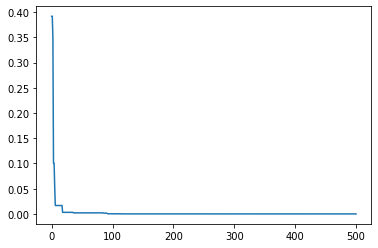

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


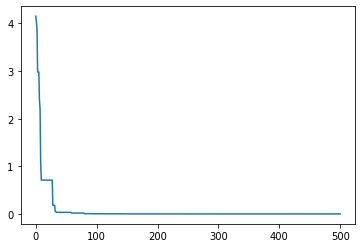

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


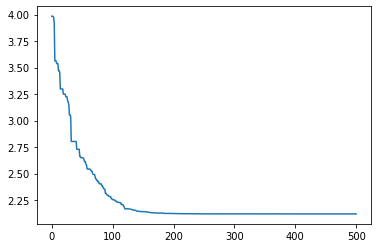

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


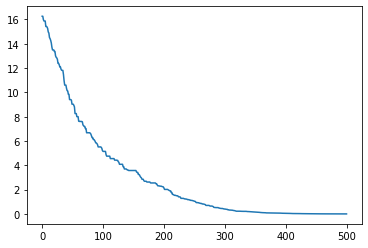

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


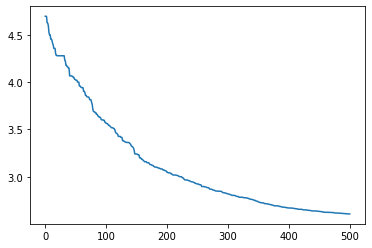

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


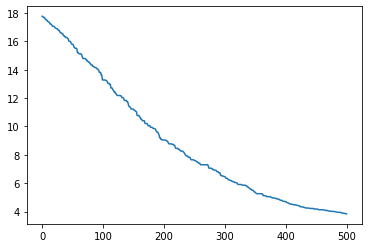

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


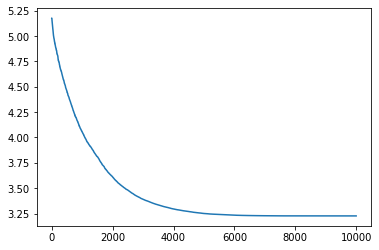

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


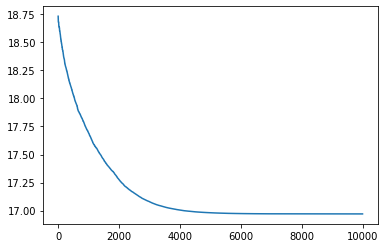

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


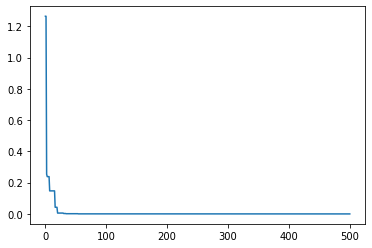

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


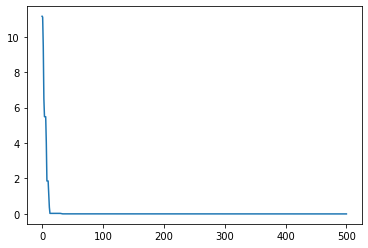

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


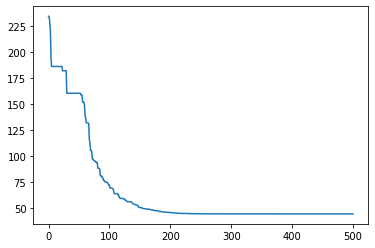

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


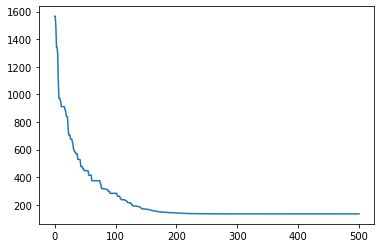

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


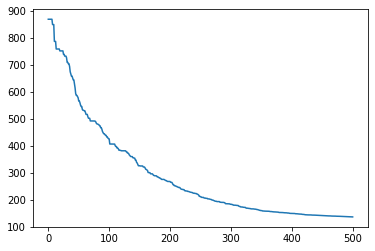

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


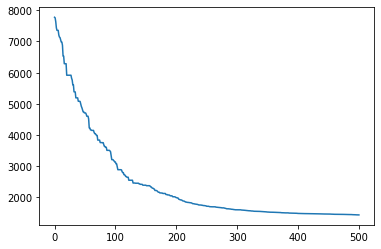

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


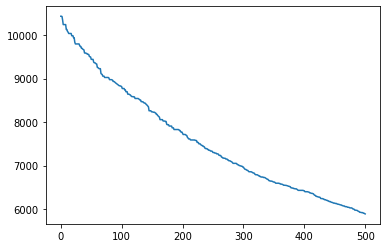

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


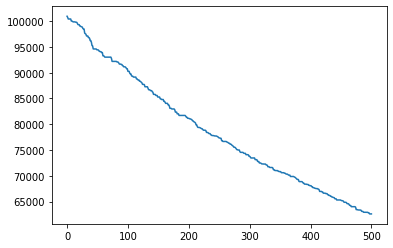

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


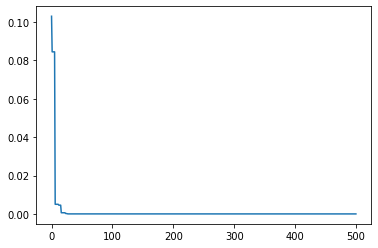

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


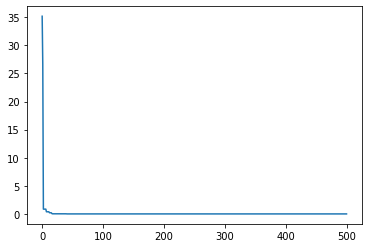

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


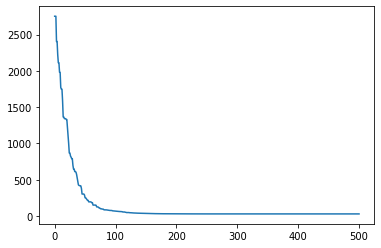

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


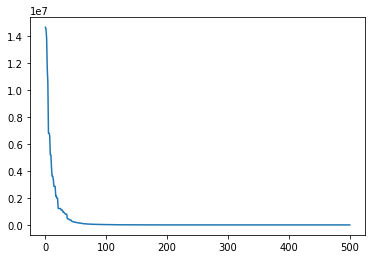

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


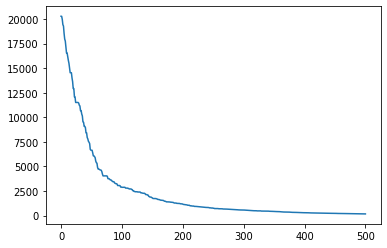

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


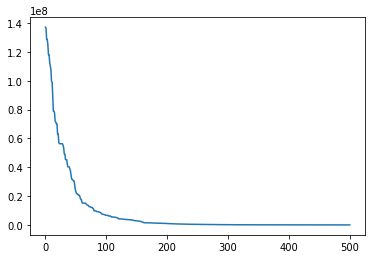

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


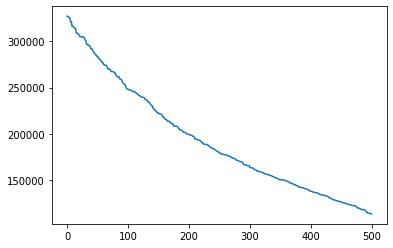

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


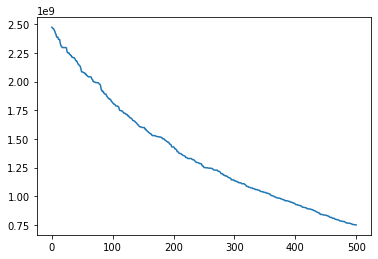

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


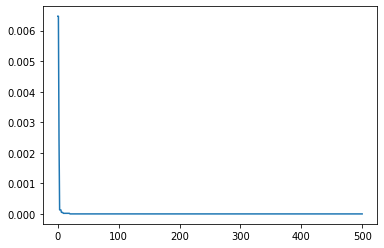

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


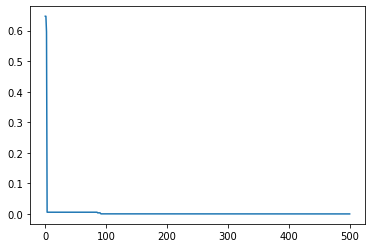

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


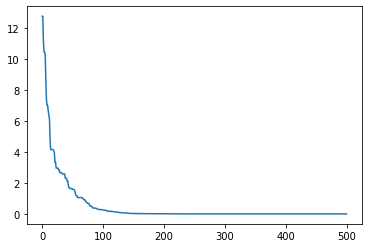

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


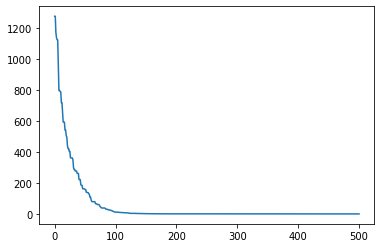

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


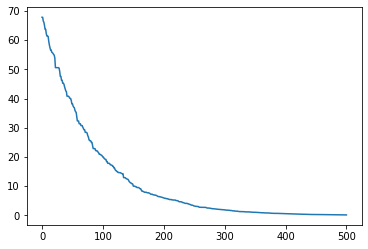

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


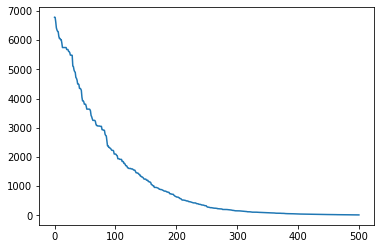

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


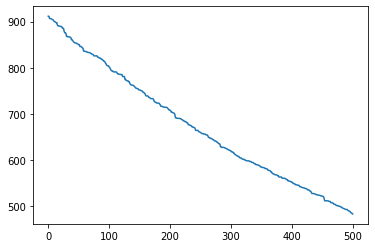

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


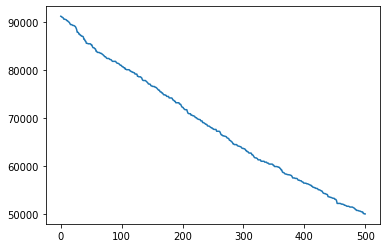

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


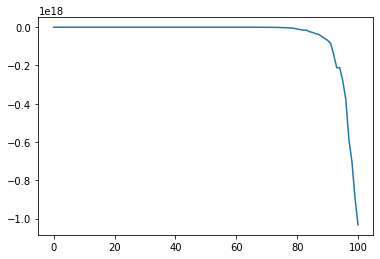

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


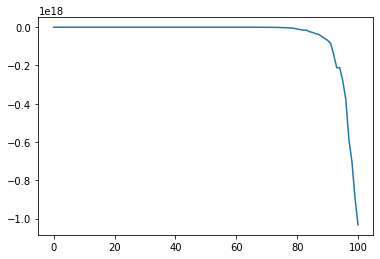

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


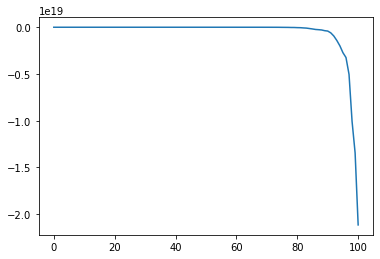

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


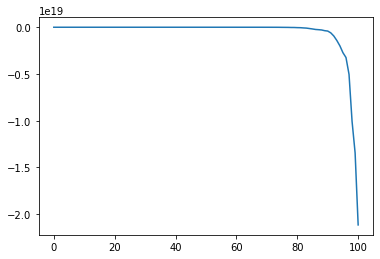

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


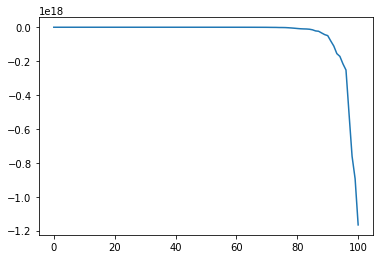

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


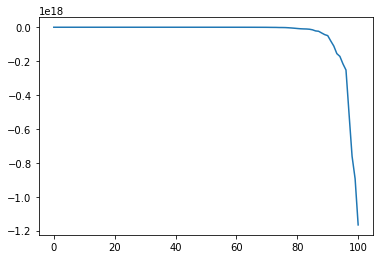

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


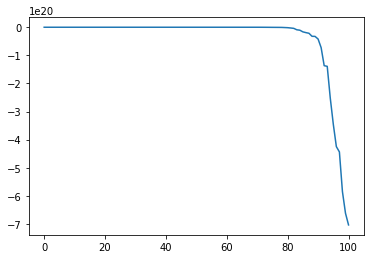

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


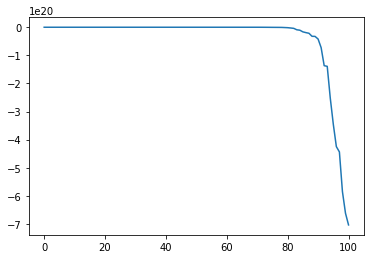

In [100]:
for ci, di in zip(config, data):
    print(ci)
    plt.plot(di[0, :, 0])
    plt.show()
    